In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score 
from sklearn.model_selection import learning_curve, ParameterGrid
import statistics

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as sf

In [2]:
raw_df = pd.read_csv('clean_kaggle_data_2020.csv', low_memory = False)

In [3]:
import_df = pd.read_csv('clean_kaggle_data_2020.csv', low_memory = False)

# Encoding and data cleaning

In [4]:
import_df.shape #checking the shape of the data

(10730, 357)

In [5]:
 import_df.head() #seeing how the first rows look like 

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,999"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"


In [6]:
import_df.columns

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q35_B_Part_4', 'Q35_B_Part_5', 'Q35_B_Part_6', 'Q35_B_Part_7',
       'Q35_B_Part_8', 'Q35_B_Part_9', 'Q35_B_Part_10', 'Q35_B_OTHER',
       'Q24_Encoded', 'Q24_buckets'],
      dtype='object', length=357)

In [7]:
import_df.iloc[0] #checking the questions

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                           What is your age (# years)?
Q2                                                What is your gender? - Selected Choice
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
                                                             ...                        
Q35_B_Part_9                           In the next 2 years, do you hope to become mor...
Q35_B_Part_10                          In the next 2 years, do you hope to become mor...
Q35_B_OTHER                            In the next 2 years, do you hope to become mor...
Q24_Encoded                                                                          NaN
Q24_buckets                                                                          NaN
Name: 0, Length: 357,

In [8]:
import_df.Q24_buckets.value_counts()

0-9,999            4441
10,000-19,999      1114
20,000-29,999       714
100,000-124,999     573
40,000-49,999       552
30,000-39,999       540
50,000-59,999       510
60,000-69,999       408
70,000-79,999       394
150,000-199,999     347
125,000-149,999     315
90,000-99,999       280
80,000-89,999       273
>250,000            153
200,000-249,999     115
Name: Q24_buckets, dtype: int64

In [9]:
#Note: bucket 14 to correspone to > 250,000 will be treated as encoded label 13 because > 250,000 is no longer a defined range (compared to the rest of the encodings)

# Data Cleaning

In [10]:
for idx, line in enumerate(import_df.iloc[0].values.tolist()):
    print(idx, line)

0 Duration (in seconds)
1 What is your age (# years)?
2 What is your gender? - Selected Choice
3 In which country do you currently reside?
4 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
5 Select the title most similar to your current role (or most recent title if retired): - Selected Choice
6 For how many years have you been writing code and/or programming?
7 What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python
8 What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R
9 What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL
10 What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C
11 What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++
12 What programming languages do

Notes
- For questions involving (Select all that apply), I will convert all the answers into 1's and NaN into 0, then I will take the sum of the 1's and find the sum. This will answer how many of the respondents have answerd none, once, or more.
- Given that there are answers with "None", all columns like this will be dropped because if the respondant answered "None", then none of the other options would be marked 1, thus the sum would be 0
- I will also be sure to isolate Q24_encoded and Q24_buckets.
- I will drop the column on duration, since how a long a data scientist took to answer the question is not related to their pay
- Columns involving age, gender, country, highest level of formal education, and years of coding experience will be converted into encoded values

In [11]:
Q24_buckets = import_df[['Q24_buckets']].copy()
Q24_Encoded = import_df[['Q24_Encoded']].copy()

Q24_buckets.drop(labels = [0], axis = 0, inplace = True)
Q24_Encoded.drop(labels = [0], axis = 0, inplace = True)

Q24_buckets = Q24_buckets.fillna(value = 0, inplace = False)
Q24_Encoded = Q24_Encoded.fillna(value= 0, inplace = False)

In [12]:
Q24_Encoded.Q24_Encoded.unique()

array([10.,  1., 11.,  7.,  3.,  9.,  0., 12.,  6., 14.,  4.,  2.,  8.,
        5., 13.])

In [13]:
Q24_Encoded.value_counts()

Q24_Encoded
0.0            4441
1.0            1114
2.0             714
10.0            573
4.0             552
3.0             540
5.0             510
6.0             408
7.0             394
12.0            347
11.0            315
9.0             280
8.0             273
14.0            153
13.0            115
dtype: int64

array([[<AxesSubplot:title={'center':'Q24_Encoded'}>]], dtype=object)

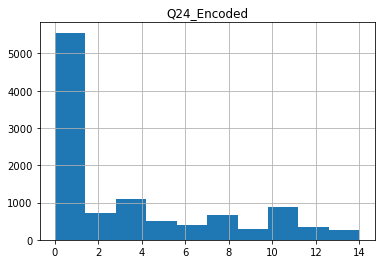

In [14]:
Q24_Encoded.hist()

In [15]:
import_df = import_df.drop(labels = ['Q24_Encoded', 'Q24_buckets', 'Time from Start to Finish (seconds)'], axis = 1, inplace = False)

In [16]:
import_df = import_df.fillna(value = 0, inplace = False)

In [17]:
none_columns = []
for idx, line in enumerate(import_df.iloc[0].values.tolist()):
    if "None" in line:
        all_columns = import_df.columns.tolist()
        none_columns.append(all_columns[idx])

In [18]:
import_df = import_df.drop(labels = none_columns, axis = 1, inplace = False)

In [19]:
import_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_OTHER
0,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,0,...,0,0,0,0,0,0,0,0,0,0
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import_df.drop(labels = [0], axis = 0, inplace = True) #now removing the first row since those are just the questions

In [21]:
import_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_OTHER
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,0,...,0,0,0,0,0,0,0,0,0,0
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0,R,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
encoding_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'] #This is to convert all the different answer such as age group, gender, and location into encodings

In [23]:
encoding_dict = {}

for col in encoding_list:
    encoding_values = []
    unique_string_list = []
    
    for encoding, unique_string in enumerate(import_df[col].unique()):
        encoding_values.append(encoding)
        unique_string_list.append(unique_string)
    
    col_dict = {}
    
    for idx, item in enumerate(encoding_values):
        col_dict[unique_string_list[idx]] = encoding_values[idx]
        
    encoding_dict[col] = col_dict

In [24]:
encoding_dict

{'Q1': {'30-34': 0,
  '35-39': 1,
  '22-24': 2,
  '55-59': 3,
  '50-54': 4,
  '25-29': 5,
  '18-21': 6,
  '40-44': 7,
  '60-69': 8,
  '45-49': 9,
  '70+': 10},
 'Q2': {'Man': 0,
  'Woman': 1,
  'Nonbinary': 2,
  'Prefer not to say': 3,
  'Prefer to self-describe': 4},
 'Q3': {'United States of America': 0,
  'Argentina': 1,
  'Germany': 2,
  'Canada': 3,
  'Switzerland': 4,
  'India': 5,
  'Russia': 6,
  'South Africa': 7,
  'Netherlands': 8,
  'Pakistan': 9,
  'Other': 10,
  'Indonesia': 11,
  'Belarus': 12,
  'Ukraine': 13,
  'Saudi Arabia': 14,
  'Taiwan': 15,
  'China': 16,
  'Italy': 17,
  'United Arab Emirates': 18,
  'Colombia': 19,
  'Viet Nam': 20,
  'United Kingdom of Great Britain and Northern Ireland': 21,
  'Egypt': 22,
  'Brazil': 23,
  'Mexico': 24,
  'Poland': 25,
  'Nigeria': 26,
  'France': 27,
  'Belgium': 28,
  'Turkey': 29,
  'Spain': 30,
  'Iran, Islamic Republic of...': 31,
  'Japan': 32,
  'Tunisia': 33,
  'Romania': 34,
  'Republic of Korea': 35,
  'Chile': 36,

In [25]:
import_df = import_df.replace(encoding_dict)
import_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_OTHER
1,0,0,0,0,0,0,Python,R,SQL,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,2,2,2,0,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,2,3,2,0,R,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#I will now separate the already encoded responses from the others

In [27]:
survey_array = import_df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q5']].copy().values

In [28]:
survey_array

array([[ 0,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  2,  2],
       ...,
       [ 0,  0, 23,  0,  3,  3],
       [ 2,  0,  5,  1,  1,  1],
       [ 2,  0,  9,  0,  8,  8]], dtype=int64)

In [29]:
import_df = import_df.drop(labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'], axis = 1, inplace = False)

In [30]:
import_df

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,...,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_OTHER
1,Python,R,SQL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,Java,Javascript,0,0,Bash,...,0,0,0,0,0,0,0,0,0,0
3,Python,0,SQL,0,0,0,0,0,0,Bash,...,0,0,0,0,0,0,0,0,0,0
4,Python,0,SQL,0,0,0,0,0,0,Bash,...,0,0,0,0,0,0,0,0,0,0
5,0,R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,Python,0,0,0,C++,0,0,0,0,0,...,0,0,0,0,TensorBoard,0,0,Trains,0,0
10726,0,0,SQL,C,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10727,Python,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10728,Python,0,SQL,C,0,Java,Javascript,0,0,0,...,Neptune.ai,Weights & Biases,0,0,TensorBoard,0,0,Trains,0,0


In [31]:
dummy_df = pd.get_dummies(import_df) #Here comes the one-hot encoding and the summing of the respective question responses

In [32]:
dummy_df.head()

,Q7_Part_1_0,Q7_Part_1_Python,Q7_Part_2_0,Q7_Part_2_R,Q7_Part_3_0,Q7_Part_3_SQL,Q7_Part_4_0,Q7_Part_4_C,Q7_Part_5_0,Q7_Part_5_C++,...,Q35_B_Part_6_0,Q35_B_Part_6_ Guild.ai,Q35_B_Part_7_0,Q35_B_Part_7_ Polyaxon,Q35_B_Part_8_0,Q35_B_Part_8_ Trains,Q35_B_Part_9_0,Q35_B_Part_9_ Domino Model Monitor,Q35_B_OTHER_0,Q35_B_OTHER_Other
1,0,1,0,1,0,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
2,1,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,0,1,1,0,0,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
5,1,0,0,1,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0


In [33]:
#removing all columns with "_0" in the encodings
zeros_columns = []
for column in dummy_df.columns.tolist():
    if "_0" in column:
        zeros_columns.append(column)

In [34]:
dummy_df = dummy_df.drop(labels = zeros_columns, axis = 1, inplace = False) #this removes the one-hot encoding with 'zero' in the title

In [35]:
question_numbers = ['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35']

In [36]:
summed_encoded = np.zeros((len(dummy_df), len(question_numbers)))

In [37]:
col_questions = []
for question_idx, question in enumerate(question_numbers):
    col_list = []
    for col_name in dummy_df.columns.tolist():
        if question in col_name:
            col_list.append(col_name)
    col_questions.append(col_list)
        
        
        

In [38]:
for question_idx, columns in enumerate(question_numbers):
    question_df = dummy_df[col_questions[question_idx]].copy()
    
    for sample_idx in range(len(question_df)):
        summed_encoded[sample_idx, question_idx] = question_df.iloc[sample_idx].sum()      
    

In [39]:
summed_encoded

array([[ 3.,  1.,  3., ...,  0.,  0.,  0.],
       [ 3.,  1.,  4., ...,  0.,  0.,  0.],
       [ 3.,  1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  1.,  2., ...,  0.,  0.,  0.],
       [ 5.,  1.,  5., ...,  6., 10.,  4.],
       [ 1.,  1.,  1., ...,  5.,  3.,  2.]])

In [40]:
concat_array = np.concatenate((survey_array, summed_encoded), axis = 1) #combining the two arrays of data back into one

In [41]:
survey_df = pd.DataFrame(data = concat_array, columns = (['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'] + question_numbers))

In [42]:
survey_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,...,3.0,4.0,1.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,1.0,0.0,...,2.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,...,2.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,2.0,3.0,3.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
survey_df.isnull().sum(axis = 0) #checking if there are any NaN values missed

Q1     0
Q2     0
Q3     0
Q4     0
Q5     0
Q6     0
Q7     0
Q8     0
Q9     0
Q10    0
Q11    0
Q12    0
Q13    0
Q14    0
Q15    0
Q16    0
Q17    0
Q18    0
Q19    0
Q20    0
Q21    0
Q22    0
Q23    0
Q24    0
Q25    0
Q26    0
Q27    0
Q28    0
Q29    0
Q30    0
Q31    0
Q32    0
Q33    0
Q34    0
Q35    0
dtype: int64

# Exploratory data analysis and feature selection

<AxesSubplot:xlabel='Q1', ylabel='count'>

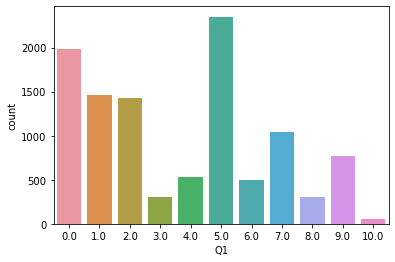

In [44]:
sns.countplot(x = 'Q1', data = survey_df)

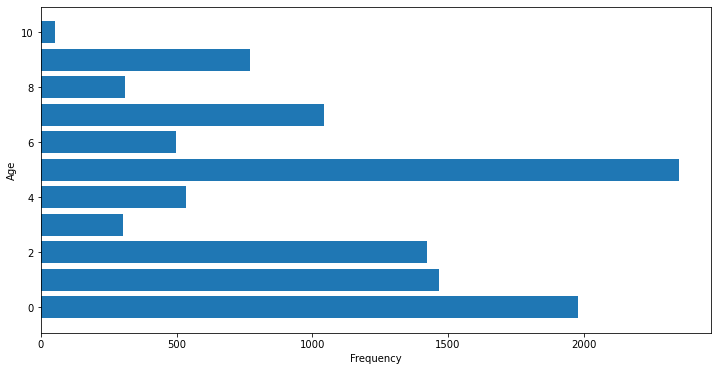

In [45]:
labels, count = np.unique(survey_df['Q1'], return_counts = True)
plt.figure(figsize = (12, 6))
plt.barh(labels, count)
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.show()

Note: Mostly Under 1 year or 1-2 years

Encodings
{'Q1': {'30-34': 0,
  '35-39': 1,
  '22-24': 2,
  '55-59': 3,
  '50-54': 4,
  '25-29': 5,
  '18-21': 6,
  '40-44': 7,
  '60-69': 8,
  '45-49': 9,
  '70+': 10},

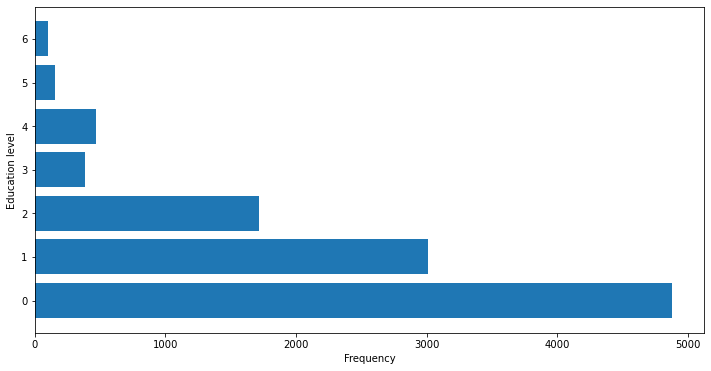

In [46]:
labels, count = np.unique(survey_df['Q4'], return_counts = True)
plt.figure(figsize = (12, 6))
plt.barh(labels, count)
plt.xlabel('Frequency')
plt.ylabel('Education level')
plt.show()

Encodings: 'Q4': {'Master’s degree': 0,
  'Bachelor’s degree': 1,
  'Doctoral degree': 2,
  'Some college/university study without earning a bachelor’s degree': 3,
  'Professional degree': 4,
  'I prefer not to answer': 5,
  'No formal education past high school': 6},
 'Q5': {'Data Engineer': 0,

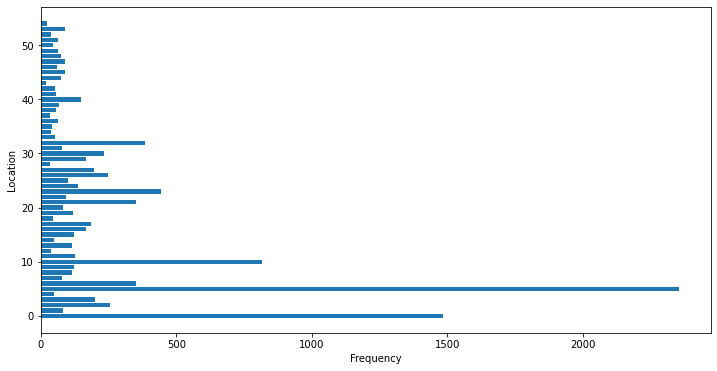

In [47]:
labels, count = np.unique(survey_df['Q3'], return_counts = True)
plt.figure(figsize = (12, 6))
plt.barh(labels, count)
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()

In [48]:
#Mostly from the US, India, and "Other"

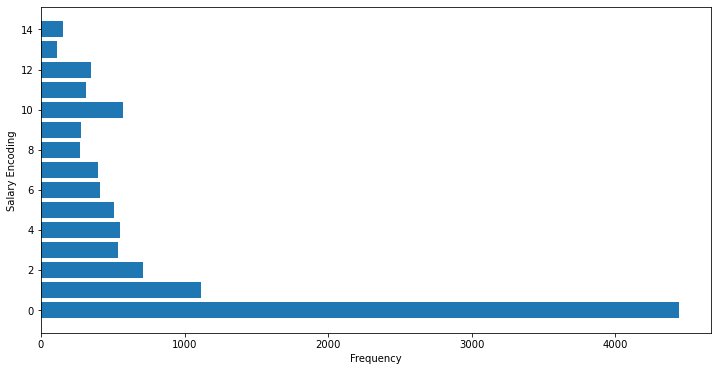

In [49]:
labels, count = np.unique(Q24_Encoded, return_counts = True)
plt.figure(figsize = (12, 6))
plt.barh(labels, count)
plt.xlabel('Frequency')
plt.ylabel('Salary Encoding')
plt.show()

Note: Based on this data alone, I expect the model to be biased in outputting label 0

In [50]:
exploratory_df = survey_df.join(other = Q24_Encoded, on = 'Q35', how = 'left')

In [51]:
exploratory_df.shape

(10729, 36)

In [52]:
exploratory_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q24_Encoded
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,...,4.0,1.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,NaN
1,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,1.0,0.0,...,2.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN
3,1.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,...,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0
4,1.0,0.0,0.0,2.0,3.0,3.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


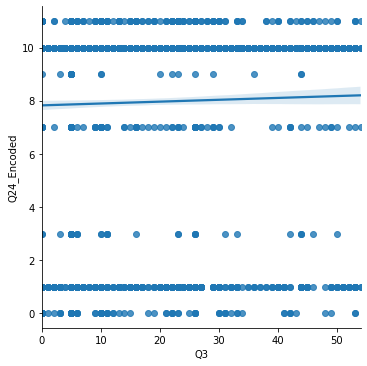

In [53]:
sns.lmplot(x = 'Q3', y = 'Q24_Encoded', data = exploratory_df)

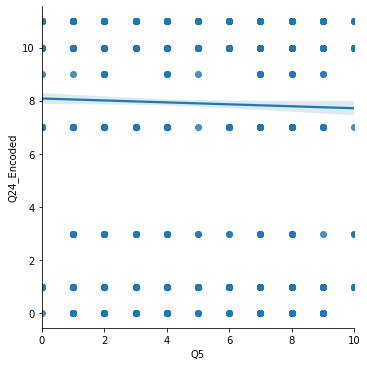

In [54]:
sns.lmplot(x = 'Q5', y = 'Q24_Encoded', data = exploratory_df)

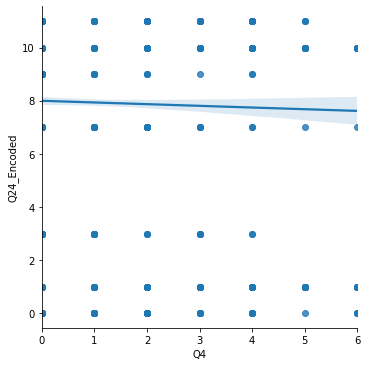

In [55]:
sns.lmplot(x = 'Q4', y = 'Q24_Encoded', data = exploratory_df)

Notes 
- No clear correlation to encoded salaries

# Ordinal logistic regression - model implementation

In [56]:
x = survey_df.copy()
y = Q24_Encoded.copy()

train_features, val_features, train_labels, val_labels = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)

In [57]:
x.shape

(10729, 35)

In [58]:
ordinal_train_predictions = np.zeros((len(x), 14))

cross_val = KFold(n_splits = 10, shuffle = True)
cross_val.get_n_splits(train_features)
scaler = StandardScaler()

cumulative_accuracy = []
cumulative_f1 = []
                       

Hyperparameters for logistic regression are as follows:
- penalty (l1, l2, elasticnet, none) default = l2
- dual (bool)
- tol (Float) tolerance for stopping criteria
- C (float) -> inverse regularization strength.
- fit_intercept: bool (default = True)
- Intercept_scaling: float (only when using sovler liblinear)
- class_weight (weights association with classes as a dictionairy)
- random_state
- solver (newton-cg, sag, saga, lbfgs'
- max_iter (int)
- multi_class 
- verbose
- warm_start
- n_jobs
- l1_ratio

Chosen parameters
- max_iter, due to errors showing total no of iterations reached
- regularization strength C, due to a wide range of possible hyperparameters

In [59]:
ordinal_train_predictions.shape

(10729, 14)

In [60]:
# 0 vs 1-13

#Re-label the encodings based on what condition we're finding 
ordinal_val0 = val_labels.copy()
ordinal_val0 = ordinal_val0.values
ordinal_val0 = np.where(ordinal_val0 < 1, 0, 1)

ordinal_train0 = train_labels.copy()
ordinal_train0 = ordinal_train0.values
ordinal_train0 = np.where(ordinal_train0 < 1, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train0[train_idx], ordinal_train0[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    
    predict_test_proba = model.predict_proba(x_test)
    
    #assign the probabilities. With the ordinal method, the other probabilities will be subtracted (shown later)
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][0] = predict_test_proba[idx][0]
    
    #Making predictions to track performance
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    #performance metrics
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))
    



Bucket accuracy: 0.6828621126642082
accuracy stdev: 0.012851010490432182
Bucket f1: 0.7486635667808689
F1 stdev: 0.013551725774726379


In [61]:
# 0-1 vs 2-13
ordinal_val1 = val_labels.copy()
ordinal_val1 = ordinal_val1.values
ordinal_val1 = np.where(ordinal_val1 < 2, 0, 1)

ordinal_train1 = train_labels.copy()
ordinal_train1 = ordinal_train1.values
ordinal_train1 = np.where(ordinal_train1 < 2, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train1[train_idx], ordinal_train1[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][1] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][0]
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.6553622551294263
accuracy stdev: 0.017101426476281684
Bucket f1: 0.6405159844856055
F1 stdev: 0.01829474405646536


In [62]:
#0-2 vs 3-13
ordinal_val2 = val_labels.copy()
ordinal_val2 = ordinal_val2.values
ordinal_val2 = np.where(ordinal_val2 < 3, 0, 1)

ordinal_train2 = train_labels.copy()
ordinal_train2 = ordinal_train2.values
ordinal_train2 = np.where(ordinal_train2 < 3, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train2[train_idx], ordinal_train2[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][2] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.6635158787661698
accuracy stdev: 0.014581477223126941
Bucket f1: 0.557372849947104
F1 stdev: 0.0188805653766975


In [63]:
#0-3 vs 4-13

ordinal_val3 = val_labels.copy()
ordinal_val3 = ordinal_val3.values
ordinal_val3 = np.where(ordinal_val3 < 4, 0, 1)

ordinal_train3 = train_labels.copy()
ordinal_train3 = ordinal_train3.values
ordinal_train3 = np.where(ordinal_train3 < 4, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train3[train_idx], ordinal_train3[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][3] = predict_test_proba[idx][0] -   ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.6861238877536898
accuracy stdev: 0.020405371723064634
Bucket f1: 0.4833091160207919
F1 stdev: 0.032872755586440476


In [64]:
#0-4 vs 5-13

ordinal_val4 = val_labels.copy()
ordinal_val4 = ordinal_val4.values
ordinal_val4 = np.where(ordinal_val4 < 5, 0, 1)

ordinal_train4 = train_labels.copy()
ordinal_train4 = ordinal_train4.values
ordinal_train4 = np.where(ordinal_train4 < 5, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train4[train_idx], ordinal_train4[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][4] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.7248076719555183
accuracy stdev: 0.012231720354782968
Bucket f1: 0.4109131967802674
F1 stdev: 0.025211598431619936


In [65]:
#0-5 vs 6-13 

ordinal_val5 = val_labels.copy()
ordinal_val5 = ordinal_val5.values
ordinal_val5 = np.where(ordinal_val5 < 6, 0, 1)

ordinal_train5 = train_labels.copy()
ordinal_train5 = ordinal_train5.values
ordinal_train5 = np.where(ordinal_train5 < 6, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train5[train_idx], ordinal_train5[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][5] = predict_test_proba[idx][0] -ordinal_train_predictions[sample_idx][4]- ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
        #print(ordinal_train_predictions[sample_idx][5])
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))


Bucket accuracy: 0.7595275310642016
accuracy stdev: 0.011175259801114126
Bucket f1: 0.3406434984957826
F1 stdev: 0.026008864801092373


In [66]:
#0-6 vs 7-13 
ordinal_val6 = val_labels.copy()
ordinal_val6 = ordinal_val6.values
ordinal_val6 = np.where(ordinal_val6 < 7, 0, 1)

ordinal_train6 = train_labels.copy()
ordinal_train6 = ordinal_train6.values
ordinal_train6 = np.where(ordinal_train6 < 7, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train6[train_idx], ordinal_train6[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][6] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][4]- ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
        
    
    predict_test = model.predict(x_test)
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))


Bucket accuracy: 0.7931962682253718
accuracy stdev: 0.015262917221348189
Bucket f1: 0.30864234420350856
F1 stdev: 0.04845411943686502


In [67]:
#0-12 vs 13 
ordinal_val13 = val_labels.copy()
ordinal_val13 = ordinal_val13.values
ordinal_val13 = np.where(ordinal_val13 < 13, 0, 1)

ordinal_train13 = train_labels.copy()
ordinal_train13 = ordinal_train13.values
ordinal_train13 = np.where(ordinal_train13 < 13, 0, 1)

bucket_accuracy = []
bucket_f1 = []

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train13[train_idx], ordinal_train13[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][13] = predict_test_proba[idx][1]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.9741353718070831
accuracy stdev: 0.003950433334749065
Bucket f1: 0.0
F1 stdev: 0.0


In [68]:
#0-11 vs 12-13
ordinal_val12 = val_labels.copy()
ordinal_val12 = ordinal_val12.values
ordinal_val12 = np.where(ordinal_val12 < 12, 0, 1)

ordinal_train12 = train_labels.copy()
ordinal_train12 = ordinal_train12.values
ordinal_train12 = np.where(ordinal_train12 < 12, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train12[train_idx], ordinal_train12[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][12] = predict_test_proba[idx][1] - ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))


Bucket accuracy: 0.9578240540987921
accuracy stdev: 0.017630468720182486
Bucket f1: 0.0017241379310344823
F1 stdev: 0.007710579232757895


In [69]:
#0-10 vs 11-13
ordinal_val11= val_labels.copy()
ordinal_val11 = ordinal_val11.values
ordinal_val11 = np.where(ordinal_val11 < 11, 0, 1)

ordinal_train11 = train_labels.copy()
ordinal_train11 = ordinal_train11.values
ordinal_train11 = np.where(ordinal_train11 < 11, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train11[train_idx], ordinal_train11[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][11] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][12]-ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.9426785993724294
accuracy stdev: 0.02659079882000719
Bucket f1: 0.01306572347460161
F1 stdev: 0.025503501121634648


In [70]:
#0-9 vs 10-13
ordinal_val10= val_labels.copy()
ordinal_val10 = ordinal_val10.values
ordinal_val10 = np.where(ordinal_val10 < 10, 0, 1)

ordinal_train10 = train_labels.copy()
ordinal_train10 = ordinal_train10.values
ordinal_train10 = np.where(ordinal_train10 < 10, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train10[train_idx], ordinal_train10[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][10] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.9235127309632548
accuracy stdev: 0.04075326764667846
Bucket f1: 0.04252218657930959
F1 stdev: 0.05795372210226623


In [71]:
#0-8 vs 9-13

ordinal_val9= val_labels.copy()
ordinal_val9 = ordinal_val9.values
ordinal_val9 = np.where(ordinal_val9 < 9, 0, 1)

ordinal_train9 = train_labels.copy()
ordinal_train9 = ordinal_train9.values
ordinal_train9 = np.where(ordinal_train9 < 9, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train9[train_idx], ordinal_train9[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][9] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.9074222479111885
accuracy stdev: 0.04928785767278281
Bucket f1: 0.0720758542580508
F1 stdev: 0.08107963005989059


In [72]:
#0-7 vs 8-13

ordinal_val8= val_labels.copy()
ordinal_val8 = ordinal_val8.values
ordinal_val8 = np.where(ordinal_val8 < 8, 0, 1)

ordinal_train8 = train_labels.copy()
ordinal_train8 = ordinal_train8.values
ordinal_train8 = np.where(ordinal_train8 < 8, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train8[train_idx], ordinal_train8[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][8] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][9]-ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.8930063146011924
accuracy stdev: 0.05579184320571418
Bucket f1: 0.10092350973376307
F1 stdev: 0.09999335211786833


In [73]:
#0-6 vs 7-13 (perspective of 7)

ordinal_val7= val_labels.copy()
ordinal_val7 = ordinal_val7.values
ordinal_val7 = np.where(ordinal_val7 < 7, 0, 1)

ordinal_train7 = train_labels.copy()
ordinal_train7 = ordinal_train7.values
ordinal_train7 = np.where(ordinal_train7 < 7, 0, 1)

for train_idx, test_idx in cross_val.split(train_features):
    model = LogisticRegression()

    x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
    y_train, y_test = ordinal_train7[train_idx], ordinal_train7[test_idx]
    
    #scaling needed due to encodings using the sum of different values 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    model.fit(x_train, y_train)
    
    model_params = model.get_params()
    #print(model_params)
    
    predict_test_proba = model.predict_proba(x_test)
    
    for idx, sample_idx in enumerate(test_idx):
        ordinal_train_predictions[sample_idx][7] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][8]-ordinal_train_predictions[sample_idx][9]-ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]
    
    predict_test = model.predict(x_test)
    
    fold_accuracy = accuracy_score(y_test, predict_test)
    fold_f1 = f1_score(y_test, predict_test)
    
    bucket_accuracy.append(fold_accuracy)
    bucket_f1.append(fold_f1)
    cumulative_accuracy.append(fold_accuracy)
    cumulative_f1.append(fold_f1)

    
print("Bucket accuracy: " + str(statistics.mean(bucket_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(bucket_accuracy)))
print("Bucket f1: " + str(statistics.mean(bucket_f1)))
print("F1 stdev: " + str(statistics.stdev(bucket_f1)))

Bucket accuracy: 0.8788308315665708
accuracy stdev: 0.062419414164848204
Bucket f1: 0.1305196832640855
F1 stdev: 0.11817748735212984


In [74]:
#model outputs
ordinal_train_predictions

array([[0.25271908, 0.07087703, 0.07947534, ..., 0.03675435, 0.02311383,
        0.01253384],
       [0.13144336, 0.08419066, 0.05365157, ..., 0.03688686, 0.1717407 ,
        0.08515812],
       [0.12966448, 0.08029547, 0.04975649, ..., 0.00109275, 0.22378871,
        0.13049002],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [75]:
#seeing one sample in particular to see all inputs
ordinal_train_predictions[0]


array([0.25271908, 0.07087703, 0.07947534, 0.08989638, 0.06673618,
       0.06204839, 0.14825658, 0.06880048, 0.0295967 , 0.02585959,
       0.08860963, 0.03675435, 0.02311383, 0.01253384])

In [76]:
print("Cumulative accuracy: " + str(statistics.mean(cumulative_accuracy)))
print("accuracy stdev: " + str(statistics.stdev(cumulative_accuracy)))
print("Cumulative f1 score: " + str(statistics.mean(cumulative_f1)))
print("F1 stdev: " + str(statistics.stdev(cumulative_f1)))

Cumulative accuracy: 0.7940865304660415
accuracy stdev: 0.10210169085591361
Cumulative f1 score: 0.31454988139732337
F1 stdev: 0.22926867776929663


# Ordinal logisitc regression - model tuning

Hyperparameters for logistic regression are as follows:
- penalty (l1, l2, elasticnet, none) default = l2
- dual (bool)
- tol (Float) tolerance for stopping criteria
- C (float) -> inverse regularization strength.
- fit_intercept: bool (default = True)
- Intercept_scaling: float (only when using sovler liblinear)
- class_weight (weights association with classes as a dictionairy)
- random_state
- solver (newton-cg, sag, saga, lbfgs'
- max_iter (int)
- multi_class 
- verbose
- warm_start
- n_jobs
- l1_ratio

Chosen parameters
- max_iter, due to errors showing total no of iterations reached
- regularization strength C, due to a wide range of possible hyperparameters

In [77]:
ordinal_train_predictions = np.zeros((len(x), 14))

cross_val = KFold(n_splits = 10, shuffle = True)
cross_val.get_n_splits(train_features)
scaler = StandardScaler()

cumulative_accuracy = []
cumulative_f1 = []

In [78]:
# 0 vs 1-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train0[train_idx], ordinal_train0[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][0] = predict_test_proba[idx][0]

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Best parameters: 
{'C': 0.01, 'max_iter': 100}
Bucket accuracy: 0.6844966636002725
accuracy stdev: 0.014770073542659039
Bucket f1: 0.7515002955689133
F1 stdev: 0.01272674083016614


In [79]:
# 0-1 vs 2-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train1[train_idx], ordinal_train1[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][1] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][0]

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)


    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 200}
Bucket accuracy: 0.6595560241078285
accuracy stdev: 0.0193860574753703
Bucket f1: 0.6450338074865984
F1 stdev: 0.021528855271905404


In [80]:
#0-2 vs 3-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train2[train_idx], ordinal_train2[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][2] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)


    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 10, 'max_iter': 200}
Bucket accuracy: 0.666200330519306
accuracy stdev: 0.019583552947345498
Bucket f1: 0.5603574633714754
F1 stdev: 0.02456809818701375


In [81]:
#0-3 vs 4-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train3[train_idx], ordinal_train3[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][3] = predict_test_proba[idx][0] -   ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)


    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 300}
Bucket accuracy: 0.6883432244899067
accuracy stdev: 0.018300981312171744
Bucket f1: 0.4876946492198603
F1 stdev: 0.02592714474835774


In [82]:
#0-4 vs 5-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train4[train_idx], ordinal_train4[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][4] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)


    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 300}
Bucket accuracy: 0.726669081791317
accuracy stdev: 0.013579809591126625
Bucket f1: 0.41256494470720717
F1 stdev: 0.03121732534707637


In [83]:
#0-5 vs 6-13 
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train5[train_idx], ordinal_train5[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][5] = predict_test_proba[idx][0] -ordinal_train_predictions[sample_idx][4]- ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]
            #print(ordinal_train_predictions[sample_idx][5])

        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 400}
Bucket accuracy: 0.7623203920642803
accuracy stdev: 0.012268908507091449
Bucket f1: 0.3495334458460985
F1 stdev: 0.02436913197035071


In [84]:
#0-6 vs 7-13 
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train6[train_idx], ordinal_train6[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][6] = predict_test_proba[idx][0] - ordinal_train_predictions[sample_idx][5]-ordinal_train_predictions[sample_idx][4]- ordinal_train_predictions[sample_idx][3] - ordinal_train_predictions[sample_idx][2]- ordinal_train_predictions[sample_idx][1] - ordinal_train_predictions[sample_idx][0]


        predict_test = model.predict(x_test)
        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 10, 'max_iter': 200}
Bucket accuracy: 0.7949408565823001
accuracy stdev: 0.012004449706589726
Bucket f1: 0.3160907554477337
F1 stdev: 0.04568541295481581


In [85]:
#0-12 vs 13 
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train13[train_idx], ordinal_train13[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][13] = predict_test_proba[idx][1]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Best parameters: 
None
Bucket accuracy: 0
accuracy stdev: 0
Bucket f1: 0
F1 stdev: 0


In [86]:
#0-11 vs 12-13
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train10[train_idx], ordinal_train10[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][12] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 300}
Bucket accuracy: 0.866017160953133
accuracy stdev: 0.014973115558597311
Bucket f1: 0.13364303973890929
F1 stdev: 0.028331090307834504


In [87]:
#0-10 vs 11-13

parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train10[train_idx], ordinal_train10[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][11] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 10, 'max_iter': 200}
Bucket accuracy: 0.866127198373997
accuracy stdev: 0.01552587024862185
Bucket f1: 0.13703213158211355
F1 stdev: 0.04434703931331456


In [88]:
#0-9 vs 10-13

parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train9[train_idx], ordinal_train9[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][10] = predict_test_proba[idx][1] - ordinal_train_predictions[sample_idx][11] -ordinal_train_predictions[sample_idx][12]-ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 0.1, 'max_iter': 300}
Bucket accuracy: 0.8431791723991957
accuracy stdev: 0.013703913138800936
Bucket f1: 0.18943801282018377
F1 stdev: 0.03496086320823703


In [89]:
#0-8 vs 9-13

parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train8[train_idx], ordinal_train8[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][9] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))


Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 1, 'max_iter': 200}
Bucket accuracy: 0.8217395138815395
accuracy stdev: 0.010530239175980857
Bucket f1: 0.24898906241606072
F1 stdev: 0.03685450324855888


In [90]:
#0-7 vs 8-13

parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train8[train_idx], ordinal_train8[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][8] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][9]-ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 10, 'max_iter': 300}
Bucket accuracy: 0.82267150777046
accuracy stdev: 0.00842828653382135
Bucket f1: 0.25248119629426347
F1 stdev: 0.02706827878517116


In [91]:
#0-6 vs 7-13 (from label 7)

parameter_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300, 400]}

best_accuracy = 0
best_accuracy_stdev = 0
best_f1 = 0
best_f1_stdev = 0
best_grid = None 


for params in ParameterGrid(parameter_grid):
    
    bucket_accuracy = []
    bucket_f1 = []
    
    for train_idx, test_idx in cross_val.split(train_features):
        model = LogisticRegression()
        model.set_params(**params)

        x_train, x_test = train_features.values[train_idx], train_features.values[test_idx]
        y_train, y_test = ordinal_train7[train_idx], ordinal_train7[test_idx]

        #scaling needed due to encodings using the sum of different values 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        model.fit(x_train, y_train)

        model_params = model.get_params()
        #print(model_params)

        predict_test_proba = model.predict_proba(x_test)

        for idx, sample_idx in enumerate(test_idx):
            ordinal_train_predictions[sample_idx][7] = predict_test_proba[idx][1] -ordinal_train_predictions[sample_idx][8]-ordinal_train_predictions[sample_idx][9]-ordinal_train_predictions[sample_idx][10]-ordinal_train_predictions[sample_idx][11]-ordinal_train_predictions[sample_idx][12] -ordinal_train_predictions[sample_idx][13]

        predict_test = model.predict(x_test)

        fold_accuracy = accuracy_score(y_test, predict_test)
        fold_f1 = f1_score(y_test, predict_test)

        bucket_accuracy.append(fold_accuracy)
        bucket_f1.append(fold_f1)

    param_accuracy = statistics.mean(bucket_accuracy)
    param_accuracy_stdev = statistics.stdev(bucket_accuracy)
    param_f1 = (statistics.mean(bucket_f1))
    param_f1_stdev = statistics.stdev(bucket_f1)

    if param_f1 > best_f1:
        best_f1 = param_f1
        best_accuracy = param_accuracy
        best_accuracy_stdev = param_accuracy_stdev
        best_f1_stdev = param_f1_stdev
        best_grid = params


        print("Found new parameter based on F1")

print("Best parameters: ")
print(best_grid)
print("Bucket accuracy: " + str(best_accuracy))
print("accuracy stdev: " + str(best_accuracy_stdev))
print("Bucket f1: " + str(best_f1))
print("F1 stdev: " + str(best_f1_stdev))

Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Found new parameter based on F1
Best parameters: 
{'C': 10, 'max_iter': 200}
Bucket accuracy: 0.7938970614174339
accuracy stdev: 0.015903876317099774
Bucket f1: 0.31301413032194125
F1 stdev: 0.04778278129636672


# Ordinal logistic regression - Testing & Discussion

In [92]:
train_features, val_features, train_labels, val_labels = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)

In [93]:
val_features.index

Int64Index([  592,   608,   424, 10134,  5635,  5466,  9046,  5532,  8899,
             7200,
            ...
             4317,   353,   456,  5298,   239,  5424,  2588,  8999,  4872,
             8764],
           dtype='int64', length=2146)

In [94]:
x_train = train_features.values
x_train = scaler.fit_transform(x_train)

final_val_features = val_features.values
final_val_features = scaler.fit_transform(final_val_features)

In [95]:
train_features.index

Int64Index([2968, 1018, 7366, 9575, 1760, 2391, 9427, 9578, 1103, 8819,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=8583)

In [96]:
val_features.index

Int64Index([  592,   608,   424, 10134,  5635,  5466,  9046,  5532,  8899,
             7200,
            ...
             4317,   353,   456,  5298,   239,  5424,  2588,  8999,  4872,
             8764],
           dtype='int64', length=2146)

In [97]:
ordinal_train0.shape

(8583, 1)

In [98]:
val_accuracy = []
val_f1 = []

train_accuracy = []
train_f1 = []

final_ordinal_array = np.zeros((len(x), 14))

In [99]:
# 0 vs 1-13
bucket_accuracy = []
bucket_f1 = []

ordinal_val0 = val_labels.copy()
ordinal_val0 = ordinal_val0.values
ordinal_val0 = np.where(ordinal_val0 < 1, 0, 1)

ordinal_train0 = train_labels.copy()
ordinal_train0 = ordinal_train0.values
ordinal_train0 = np.where(ordinal_train0 < 1, 0, 1)
    
bucket0_final_model = LogisticRegression()
bucket0_final_model.set_params(**{'C': 0.01, 'max_iter': 200})
bucket0_final_model.fit(train_features, ordinal_train0)

bucket0_train_predict = bucket0_final_model.predict(train_features)
bucket0_train_proba = bucket0_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][0] = bucket0_train_proba[idx][0]
bucket0_train_accuracy = accuracy_score(ordinal_train0, bucket0_train_predict)
bucket0_train_f1 = f1_score(ordinal_train0, bucket0_train_predict)
train_accuracy.append(bucket0_train_accuracy)
train_f1.append(bucket0_train_f1)

bucket0_val_predict = bucket0_final_model.predict(final_val_features)
bucket0_val_proba = bucket0_final_model.predict_proba(final_val_features)
bucket0_val_accuracy = accuracy_score(ordinal_val0, bucket0_val_predict)
bucket0_val_f1 = f1_score(ordinal_val0, bucket0_val_predict)
val_accuracy.append(bucket0_val_accuracy)
val_f1.append(bucket0_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][0] = bucket0_val_proba[idx][0]




In [100]:
# 0-1 vs 2-13
ordinal_val1 = val_labels.copy()
ordinal_val1 = ordinal_val1.values
ordinal_val1 = np.where(ordinal_val1 < 2, 0, 1)

ordinal_train1 = train_labels.copy()
ordinal_train1 = ordinal_train1.values
ordinal_train1 = np.where(ordinal_train1 < 2, 0, 1)

bucket1_final_model = LogisticRegression()
bucket1_final_model.set_params(**{'C': 1, 'max_iter': 400})
bucket1_final_model.fit(train_features, ordinal_train1)

bucket1_train_predict = bucket1_final_model.predict(train_features)
bucket1_train_proba = bucket1_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][1] = bucket1_train_proba[idx][0] - final_ordinal_array[sample_idx][0]
bucket1_train_accuracy = accuracy_score(ordinal_train1, bucket1_train_predict)
bucket1_train_f1 = f1_score(ordinal_train1, bucket1_train_predict)
train_accuracy.append(bucket1_train_accuracy)
train_f1.append(bucket1_train_f1)

bucket1_val_predict = bucket1_final_model.predict(final_val_features)
bucket1_val_proba = bucket1_final_model.predict_proba(final_val_features)
bucket1_val_accuracy = accuracy_score(ordinal_val1, bucket1_val_predict)
bucket1_val_f1 = f1_score(ordinal_val1, bucket1_val_predict)
val_accuracy.append(bucket1_val_accuracy)
val_f1.append(bucket1_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][1] = bucket1_val_proba[idx][0] - final_ordinal_array[sample_idx][0]

In [101]:
#0-2 vs 3-13
ordinal_val2 = val_labels.copy()
ordinal_val2 = ordinal_val2.values
ordinal_val2 = np.where(ordinal_val2 < 3, 0, 1)

ordinal_train2 = train_labels.copy()
ordinal_train2 = ordinal_train2.values
ordinal_train2 = np.where(ordinal_train2 < 3, 0, 1)

bucket2_final_model = LogisticRegression()
bucket2_final_model.set_params(**{'C': 10, 'max_iter': 100})
bucket2_final_model.fit(train_features, ordinal_train2)

bucket2_train_predict = bucket2_final_model.predict(train_features)
bucket2_train_proba = bucket2_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][2] = bucket2_train_proba[idx][0] -final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]
bucket2_train_accuracy = accuracy_score(ordinal_train2, bucket2_train_predict)
bucket2_train_f1 = f1_score(ordinal_train2, bucket2_train_predict)
train_accuracy.append(bucket2_train_accuracy)
train_f1.append(bucket2_train_f1)

bucket2_val_predict = bucket2_final_model.predict(final_val_features)
bucket2_val_proba = bucket2_final_model.predict_proba(final_val_features)
bucket2_val_accuracy = accuracy_score(ordinal_val2, bucket2_val_predict)
bucket2_val_f1 = f1_score(ordinal_val2, bucket2_val_predict)
val_accuracy.append(bucket2_val_accuracy)
val_f1.append(bucket2_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][2] = bucket2_val_proba[idx][0] -final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]

In [102]:
#0-3 vs 4-13
ordinal_val3 = val_labels.copy()
ordinal_val3 = ordinal_val3.values
ordinal_val3 = np.where(ordinal_val3 < 4, 0, 1)

ordinal_train3 = train_labels.copy()
ordinal_train3 = ordinal_train3.values
ordinal_train3 = np.where(ordinal_train3 < 4, 0, 1)

bucket3_final_model = LogisticRegression()
bucket3_final_model.set_params(**{'C': 10, 'max_iter': 200})
bucket3_final_model.fit(train_features, ordinal_train3)

bucket3_train_predict = bucket3_final_model.predict(train_features)
bucket3_train_proba = bucket3_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][3] = bucket3_train_proba[idx][0] -final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]
bucket3_train_accuracy = accuracy_score(ordinal_train3, bucket3_train_predict)
bucket3_train_f1 = f1_score(ordinal_train3, bucket3_train_predict)
train_accuracy.append(bucket3_train_accuracy)
train_f1.append(bucket3_train_f1)

bucket3_val_predict = bucket3_final_model.predict(final_val_features)
bucket3_val_proba = bucket3_final_model.predict_proba(final_val_features)
bucket3_val_accuracy = accuracy_score(ordinal_val3, bucket3_val_predict)
bucket3_val_f1 = f1_score(ordinal_val3, bucket3_val_predict)
val_accuracy.append(bucket3_val_accuracy)
val_f1.append(bucket3_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][3] = bucket3_val_proba[idx][0] -final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]

In [103]:
#0-4 vs 5-13

ordinal_val4 = val_labels.copy()
ordinal_val4 = ordinal_val4.values
ordinal_val4 = np.where(ordinal_val4 < 5, 0, 1)

ordinal_train4 = train_labels.copy()
ordinal_train4 = ordinal_train4.values
ordinal_train4 = np.where(ordinal_train4 < 5, 0, 1)

bucket4_final_model = LogisticRegression()
bucket4_final_model.set_params(**{'C': 10, 'max_iter': 400})
bucket4_final_model.fit(train_features, ordinal_train4)

bucket4_train_predict = bucket4_final_model.predict(train_features)
bucket4_train_proba = bucket4_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][4] = bucket4_train_proba[idx][0] -final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]
bucket4_train_accuracy = accuracy_score(ordinal_train4, bucket4_train_predict)
bucket4_train_f1 = f1_score(ordinal_train4, bucket4_train_predict)
train_accuracy.append(bucket4_train_accuracy)
train_f1.append(bucket4_train_f1)

bucket4_val_predict = bucket4_final_model.predict(final_val_features)
bucket4_val_proba = bucket4_final_model.predict_proba(final_val_features)
bucket4_val_accuracy = accuracy_score(ordinal_val4, bucket4_val_predict)
bucket4_val_f1 = f1_score(ordinal_val4, bucket4_val_predict)
val_accuracy.append(bucket4_val_accuracy)
val_f1.append(bucket4_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][4] = bucket4_val_proba[idx][0] -final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]

In [104]:
#0-5 vs 6-13 

ordinal_val5 = val_labels.copy()
ordinal_val5 = ordinal_val5.values
ordinal_val5 = np.where(ordinal_val5 < 6, 0, 1)

ordinal_train5 = train_labels.copy()
ordinal_train5 = ordinal_train5.values
ordinal_train5 = np.where(ordinal_train5 < 6, 0, 1)


bucket5_final_model = LogisticRegression()
bucket5_final_model.set_params(**{'C': 10, 'max_iter': 200})
bucket5_final_model.fit(train_features, ordinal_train5)

bucket5_train_predict = bucket5_final_model.predict(train_features)
bucket5_train_proba = bucket5_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][5] = bucket5_train_proba[idx][0] -final_ordinal_array[sample_idx][4]-final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]
bucket5_train_accuracy = accuracy_score(ordinal_train5, bucket5_train_predict)
bucket5_train_f1 = f1_score(ordinal_train5, bucket5_train_predict)
train_accuracy.append(bucket5_train_accuracy)
train_f1.append(bucket5_train_f1)

bucket5_val_predict = bucket5_final_model.predict(final_val_features)
bucket5_val_proba = bucket5_final_model.predict_proba(final_val_features)
bucket5_val_accuracy = accuracy_score(ordinal_val5, bucket5_val_predict)
bucket5_val_f1 = f1_score(ordinal_val5, bucket5_val_predict)
val_accuracy.append(bucket5_val_accuracy)
val_f1.append(bucket5_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][5] = bucket5_val_proba[idx][0] -final_ordinal_array[sample_idx][4]-final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]

In [105]:
#0-6 vs 7-13 

ordinal_val6 = val_labels.copy()
ordinal_val6 = ordinal_val6.values
ordinal_val6 = np.where(ordinal_val6 < 7, 0, 1)

ordinal_train6 = train_labels.copy()
ordinal_train6 = ordinal_train6.values
ordinal_train6 = np.where(ordinal_train6 < 7, 0, 1)

bucket6_final_model = LogisticRegression()
bucket6_final_model.set_params(**{'C': 1, 'max_iter': 100})
bucket6_final_model.fit(train_features, ordinal_train6)

bucket6_train_predict = bucket6_final_model.predict(train_features)
bucket6_train_proba = bucket6_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][6] = bucket6_train_proba[idx][0] -final_ordinal_array[sample_idx][5]-final_ordinal_array[sample_idx][4]-final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]
bucket6_train_accuracy = accuracy_score(ordinal_train6, bucket6_train_predict)
bucket6_train_f1 = f1_score(ordinal_train6, bucket6_train_predict)
train_accuracy.append(bucket6_train_accuracy)
train_f1.append(bucket6_train_f1)

bucket6_val_predict = bucket6_final_model.predict(final_val_features)
bucket6_val_proba = bucket6_final_model.predict_proba(final_val_features)
bucket6_val_accuracy = accuracy_score(ordinal_val6, bucket6_val_predict)
bucket6_val_f1 = f1_score(ordinal_val6, bucket6_val_predict)
val_accuracy.append(bucket6_val_accuracy)
val_f1.append(bucket6_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][6] = bucket6_val_proba[idx][0]-final_ordinal_array[sample_idx][5] -final_ordinal_array[sample_idx][4]-final_ordinal_array[sample_idx][3]-final_ordinal_array[sample_idx][2]-final_ordinal_array[sample_idx][1] - final_ordinal_array[sample_idx][0]

In [106]:
#0-12 vs 13 

ordinal_val13 = val_labels.copy()
ordinal_val13 = ordinal_val13.values
ordinal_val13 = np.where(ordinal_val12 < 13, 0, 1)

ordinal_train13 = train_labels.copy()
ordinal_train13 = ordinal_train13.values
ordinal_train13 = np.where(ordinal_train13 < 13, 0, 1)

bucket13_final_model = LogisticRegression()
bucket13_final_model.fit(train_features, ordinal_train13)

bucket13_train_predict = bucket13_final_model.predict(train_features)
bucket13_train_proba = bucket13_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][13] = bucket13_train_proba[idx][1] 
bucket13_train_accuracy = accuracy_score(ordinal_train13, bucket13_train_predict)
bucket13_train_f1 = f1_score(ordinal_train13, bucket13_train_predict)
train_accuracy.append(bucket13_train_accuracy)
train_f1.append(bucket13_train_f1)

bucket13_val_predict = bucket13_final_model.predict(final_val_features)
bucket13_val_proba = bucket13_final_model.predict_proba(final_val_features)
bucket13_val_accuracy = accuracy_score(ordinal_val13, bucket13_val_predict)
bucket13_val_f1 = f1_score(ordinal_val13, bucket13_val_predict)
val_accuracy.append(bucket13_val_accuracy)
val_f1.append(bucket13_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][13] = bucket13_val_proba[idx][1]

In [107]:
#0-11 vs 12-13
ordinal_val12 = val_labels.copy()
ordinal_val12 = ordinal_val12.values
ordinal_val12 = np.where(ordinal_val12 < 12, 0, 1)

ordinal_train12 = train_labels.copy()
ordinal_train12 = ordinal_train12.values
ordinal_train12 = np.where(ordinal_train12 < 12, 0, 1)

bucket12_final_model = LogisticRegression()
bucket12_final_model.set_params(**{'C': 10, 'max_iter': 100})
bucket12_final_model.fit(train_features, ordinal_train12)

bucket12_train_predict = bucket12_final_model.predict(train_features)
bucket12_train_proba = bucket12_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][12] = bucket12_train_proba[idx][1] - final_ordinal_array[sample_idx][13]
bucket12_train_accuracy = accuracy_score(ordinal_train12, bucket12_train_predict)
bucket12_train_f1 = f1_score(ordinal_train12, bucket12_train_predict)
train_accuracy.append(bucket12_train_accuracy)
train_f1.append(bucket12_train_f1)

bucket12_val_predict = bucket12_final_model.predict(final_val_features)
bucket12_val_proba = bucket12_final_model.predict_proba(final_val_features)
bucket12_val_accuracy = accuracy_score(ordinal_val12, bucket12_val_predict)
bucket12_val_f1 = f1_score(ordinal_val12, bucket12_val_predict)
val_accuracy.append(bucket12_val_accuracy)
val_f1.append(bucket12_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][12] = bucket12_val_proba[idx][1] - final_ordinal_array[sample_idx][13]

In [108]:
#0-10 vs 11-13
ordinal_val11= val_labels.copy()
ordinal_val11 = ordinal_val11.values
ordinal_val11 = np.where(ordinal_val11 < 11, 0, 1)

ordinal_train11 = train_labels.copy()
ordinal_train11 = ordinal_train11.values
ordinal_train11 = np.where(ordinal_train11 < 11, 0, 1)

bucket11_final_model = LogisticRegression()
bucket11_final_model.set_params(**{'C': 1, 'max_iter': 200})
bucket11_final_model.fit(train_features, ordinal_train11)

bucket11_train_predict = bucket11_final_model.predict(train_features)
bucket11_train_proba = bucket11_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][11] = bucket11_train_proba[idx][1] - final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]
bucket11_train_accuracy = accuracy_score(ordinal_train11, bucket11_train_predict)
bucket11_train_f1 = f1_score(ordinal_train11, bucket11_train_predict)
train_accuracy.append(bucket11_train_accuracy)
train_f1.append(bucket11_train_f1)

bucket11_val_predict = bucket11_final_model.predict(final_val_features)
bucket11_val_proba = bucket11_final_model.predict_proba(final_val_features)
bucket11_val_accuracy = accuracy_score(ordinal_val11, bucket11_val_predict)
bucket11_val_f1 = f1_score(ordinal_val11, bucket11_val_predict)
val_accuracy.append(bucket11_val_accuracy)
val_f1.append(bucket11_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][11] = bucket11_val_proba[idx][1] - final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]

In [109]:
#0-9 vs 10-13
ordinal_val10= val_labels.copy()
ordinal_val10 = ordinal_val10.values
ordinal_val10 = np.where(ordinal_val9 < 10, 0, 1)

ordinal_train10 = train_labels.copy()
ordinal_train10 = ordinal_train10.values
ordinal_train10 = np.where(ordinal_train9 < 10, 0, 1)

bucket10_final_model = LogisticRegression()
bucket10_final_model.set_params(**{'C': 10, 'max_iter': 200})
bucket10_final_model.fit(train_features, ordinal_train9)

bucket10_train_predict = bucket10_final_model.predict(train_features)
bucket10_train_proba = bucket10_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][10] = bucket10_train_proba[idx][1] - final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]
bucket10_train_accuracy = accuracy_score(ordinal_train10, bucket10_train_predict)
bucket10_train_f1 = f1_score(ordinal_train10, bucket10_train_predict)
train_accuracy.append(bucket10_train_accuracy)
train_f1.append(bucket10_train_f1)

bucket10_val_predict = bucket10_final_model.predict(final_val_features)
bucket10_val_proba = bucket10_final_model.predict_proba(final_val_features)
bucket10_val_accuracy = accuracy_score(ordinal_val10, bucket10_val_predict)
bucket10_val_f1 = f1_score(ordinal_val10, bucket10_val_predict)
val_accuracy.append(bucket10_val_accuracy)
val_f1.append(bucket10_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][10] = bucket10_val_proba[idx][1] - final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]

In [110]:
#0-8 vs 9-13

ordinal_val9= val_labels.copy()
ordinal_val9 = ordinal_val9.values
ordinal_val9 = np.where(ordinal_val9 < 9, 0, 1)

ordinal_train9 = train_labels.copy()
ordinal_train9 = ordinal_train9.values
ordinal_train9 = np.where(ordinal_train9 < 9, 0, 1)


bucket9_final_model = LogisticRegression()
bucket9_final_model.set_params(**{'C': 1, 'max_iter': 400})
bucket9_final_model.fit(train_features, ordinal_train9)

bucket9_train_predict = bucket9_final_model.predict(train_features)
bucket9_train_proba = bucket9_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][9] = bucket9_train_proba[idx][1] - final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]
bucket9_train_accuracy = accuracy_score(ordinal_train9, bucket9_train_predict)
bucket9_train_f1 = f1_score(ordinal_train9, bucket9_train_predict)
train_accuracy.append(bucket9_train_accuracy)
train_f1.append(bucket9_train_f1)

bucket9_val_predict = bucket9_final_model.predict(final_val_features)
bucket9_val_proba = bucket9_final_model.predict_proba(final_val_features)
bucket9_val_accuracy = accuracy_score(ordinal_val9, bucket9_val_predict)
bucket9_val_f1 = f1_score(ordinal_val9, bucket9_val_predict)
val_accuracy.append(bucket9_val_accuracy)
val_f1.append(bucket9_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][9] = bucket9_val_proba[idx][1] - final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]

In [111]:
#0-7 vs 8-13

ordinal_val8= val_labels.copy()
ordinal_val8 = ordinal_val8.values
ordinal_val8 = np.where(ordinal_val8 < 8, 0, 1)

ordinal_train8 = train_labels.copy()
ordinal_train8 = ordinal_train8.values
ordinal_train8 = np.where(ordinal_train8 < 8, 0, 1)


bucket8_final_model = LogisticRegression()
bucket8_final_model.set_params(**{'C': 10, 'max_iter': 100})
bucket8_final_model.fit(train_features, ordinal_train8)

bucket8_train_predict = bucket8_final_model.predict(train_features)
bucket8_train_proba = bucket8_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][8] = bucket8_train_proba[idx][1] - final_ordinal_array[sample_idx][9]-final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]
bucket8_train_accuracy = accuracy_score(ordinal_train8, bucket8_train_predict)
bucket8_train_f1 = f1_score(ordinal_train8, bucket8_train_predict)
train_accuracy.append(bucket8_train_accuracy)
train_f1.append(bucket8_train_f1)

bucket8_val_predict = bucket8_final_model.predict(final_val_features)
bucket8_val_proba = bucket8_final_model.predict_proba(final_val_features)
bucket8_val_accuracy = accuracy_score(ordinal_val8, bucket8_val_predict)
bucket8_val_f1 = f1_score(ordinal_val8, bucket8_val_predict)
val_accuracy.append(bucket8_val_accuracy)
val_f1.append(bucket8_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][8] = bucket8_train_proba[idx][1] - final_ordinal_array[sample_idx][9]-final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]

In [112]:
#0-6 vs 7-13 (from the label of 7)

ordinal_val7= val_labels.copy()
ordinal_val7 = ordinal_val7.values
ordinal_val7 = np.where(ordinal_val8 < 7, 0, 1)

ordinal_train7 = train_labels.copy()
ordinal_train7 = ordinal_train7.values
ordinal_train7 = np.where(ordinal_train7 < 7, 0, 1)


bucket7_final_model = LogisticRegression()
bucket7_final_model.set_params(**{'C': 10, 'max_iter': 400})
bucket7_final_model.fit(train_features, ordinal_train7)

bucket7_train_predict = bucket7_final_model.predict(train_features)
bucket7_train_proba = bucket7_final_model.predict_proba(train_features)
for idx, sample_idx in enumerate(train_features.index):
    final_ordinal_array[sample_idx][7] = bucket7_train_proba[idx][1] - final_ordinal_array[sample_idx][8]-final_ordinal_array[sample_idx][9]-final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]
bucket7_train_accuracy = accuracy_score(ordinal_train7, bucket7_train_predict)
bucket7_train_f1 = f1_score(ordinal_train7, bucket7_train_predict)
train_accuracy.append(bucket7_train_accuracy)
train_f1.append(bucket7_train_f1)

bucket7_val_predict = bucket7_final_model.predict(final_val_features)
bucket7_val_proba = bucket7_final_model.predict_proba(final_val_features)
bucket7_val_accuracy = accuracy_score(ordinal_val7, bucket7_val_predict)
bucket7_val_f1 = f1_score(ordinal_val7, bucket7_val_predict)
val_accuracy.append(bucket7_val_accuracy)
val_f1.append(bucket7_val_f1)
for idx, sample_idx in enumerate(val_features.index):
    final_ordinal_array[sample_idx][7] = bucket7_train_proba[idx][1] - final_ordinal_array[sample_idx][8]-final_ordinal_array[sample_idx][9]-final_ordinal_array[sample_idx][10]-final_ordinal_array[sample_idx][11]-final_ordinal_array[sample_idx][12]-final_ordinal_array[sample_idx][13]

# Results

In [113]:
train_predictions = np.zeros(len(train_features))
val_predictions = np.zeros(len(val_features))

for idx, train_idx in enumerate(train_features.index):
    prediction = np.argmax(final_ordinal_array[train_idx])
    train_predictions[idx] = prediction
    
for idx, val_idx in enumerate(val_features.index):
    prediction = np.argmax(final_ordinal_array[val_idx])
    val_predictions[idx] = prediction
    

In [114]:
#Validation accuracy and F1 score
val_accuracy = accuracy_score(val_labels, val_predictions)
val_f1 = f1_score(val_labels, val_predictions, average = 'macro')

print("Validation accuracy: " + str(val_accuracy))
print("Validation f1 score: " + str(val_f1))

Validation accuracy: 0.3984156570363467
Validation f1 score: 0.05066362503131241


In [115]:
#Training accuracy and f1 score 
train_accuracy = accuracy_score(train_labels, train_predictions)
train_f1  = f1_score(train_labels, train_predictions, average = 'micro')

print("Train accuracy: " + str(train_accuracy))
print("Train f1 score: " + str(train_f1))

Train accuracy: 0.41838518000699054
Train f1 score: 0.41838518000699054


In [116]:
len(final_ordinal_array[1])

14

In [117]:
#Plot distribution of true target variable and predictions

def plot_distribution(sample_idx, target_df, ordinal_probability_array):
    one_hot_df = pd.get_dummies(target_df.Q24_Encoded) #drop 
    target = np.array(one_hot_df.iloc[idx])
    target = target[:-1]
    prediction = ordinal_probability_array[sample_idx]
    
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    
    x = np.arange(len(labels)) #label locations
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, target, width, label = "Target")
    rects2 = ax.bar(x + width/2, prediction, width, label = 'Predictions')
    
    ax.set_ylabel("Probability")
    ax.set_title("Probability vs label of sample index " + str(sample_idx))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    plt.legend(loc = 'upper right')
    
    fig.tight_layout()
    plt.show()
    

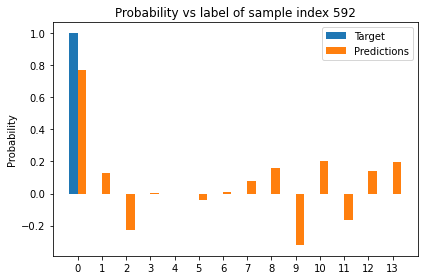

In [118]:
plot_distribution(592, Q24_Encoded, final_ordinal_array) #Validation 

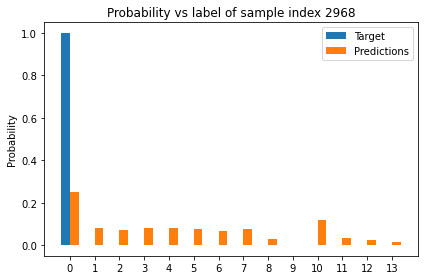

In [119]:
plot_distribution(2968, Q24_Encoded, final_ordinal_array) #train